TESTED FEATURES: 
Index(['vel5', 'vel10', 'vel15', 'vel30', 'vel60', 'acc5', 'acc10', 'acc15',
       'acc30', 'acc60', 'stoch12', 'stochDiff6012', 'RSIhl_diff',
       'RSIhl_diffROC', 'YM_diff', 'NQ_diff', 'vol', 'vol10', 'vol15', 'vol30',
       'vol60', 'volD10', 'volD15', 'volD30', 'volD60', 'volDQdiff',
       'volYMdiff', 'VIX', 'vpm5', 'vpm10', 'vpm15', 'vpm30', 'vpm60', 'ToD',
       'DoW'],
      dtype='object')
TESTING FOR: 
MOVE
OCCURANCES IN RAW DATA FOR MOVE: 
{'mv': 4576, 'nm': 3105}
Smallest Class Size: 3105 

OCCURANCES IN OPT DATA FOR MOVE: 
{'mv': 3105, 'nm': 3105}
156/156 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.4880 - loss: nan - precision: 1.0000 - recall: 0.0059 - val_accuracy: 0.5145 - val_loss: nan - val_precision: 0.0000e+00 - val_recall: 0.0000e+00


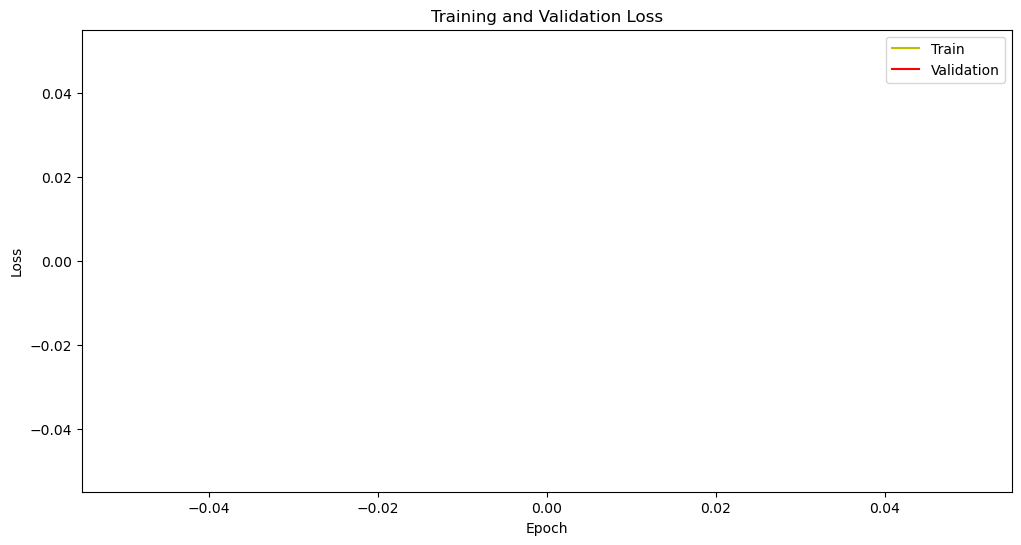

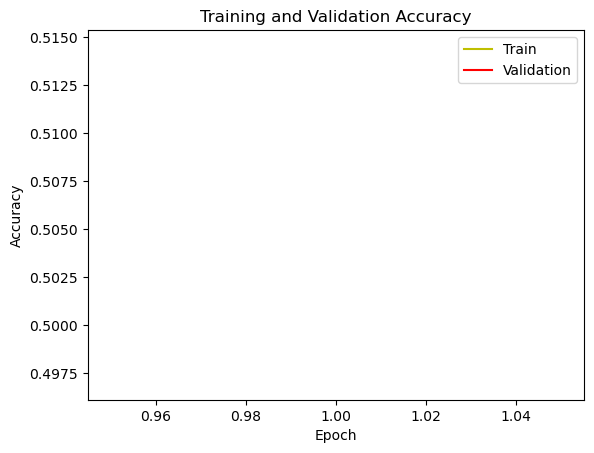

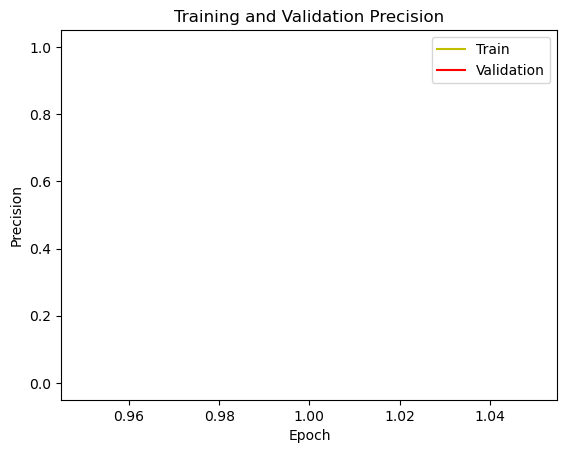

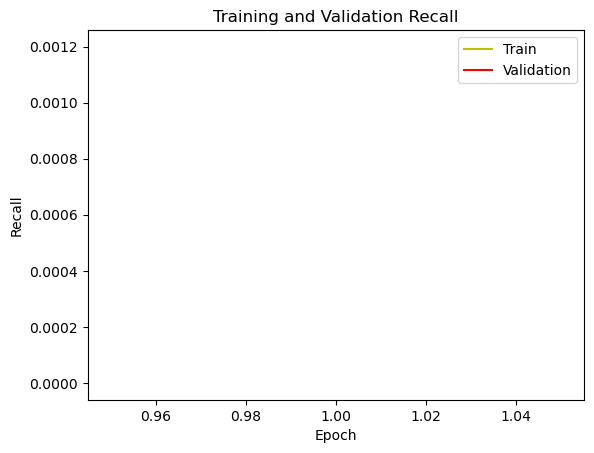

39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


c:\Users\logan\anaconda3\Lib\site-packages\sklearn\utils\_array_api.py:290: RuntimeWarning: invalid value encountered in cast
  return x.astype(dtype, copy=copy, casting=casting)


ValueError: Input y_pred contains NaN.

In [10]:
#JJ McCauley + LOGAN KELSCH 
#TEST NN 1

#IMPORT LIBRARIES-------------------------------------------------------

import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from keras.optimizers import SGD
from keras.initializers import GlorotUniform
from keras.initializers import RandomNormal
from keras.callbacks import EarlyStopping
from imblearn.over_sampling import SMOTE

#hahaha dont turn this on with high epoch or else
#tf.config.experimental.set_memory_growth

#LOAD DATA FROM CSV-------------------------------------------------------

# Load the dataset
data = pd.read_csv('catted_1.csv')

#testing random feature drops
data = data.drop(columns='FT')
data = data.drop(columns='FT.1')
data = data.drop(columns='FT.2')

data = data.drop(columns='DIR')
#data = data.drop(columns='MOVE')


#TEMP DROP PRE-DUAL-OUTPUT NN

#data = data.drop(columns='CLASS')


#confirming X and Y features post training
Xfeatures = data.columns[:-1]
Yfeatures = data.columns[-1]
print("TESTED FEATURES: ")
print(Xfeatures)
print("TESTING FOR: ")
print(Yfeatures)

#DATA OPTIMIZATION------------------------------------------------------

print("OCCURANCES IN RAW DATA FOR ", Yfeatures, ": ", sep='')
unique, counts = np.unique(data.iloc[:, -1].values, return_counts=True)
print(dict(zip(unique,counts)))

#filtering before splitting could be useful if ABSOLUTELY mostly comprised of 'in'
#MARKET HOURS!
#data = data.drop(data[data['ToD'] > 950].index)
#data = data.drop(data[data['ToD'] < 560].index)
#OTHER MODIFICATIONS
#data = data.drop(data[data['feature'] condition].index)
#data = data.drop(data[data['vol'] < 10000].index)

#upRows = data.drop(data[data['DIR'] != 'up'].index)
#dnRows = data.drop(data[data['DIR'] != 'dn'].index)
mvRows = data.drop(data[data['MOVE'] != 'mv'].index)
nmRows = data.drop(data[data['MOVE'] != 'nm'].index)

smallestClass = min(mvRows.index.size, nmRows.index.size)
#smallestClass = min(upRows.index.size, dnRows.index.size)
print('Smallest Class Size:',smallestClass,'\n')

#upRows = upRows.iloc[0:smallestClass]
#dnRows = dnRows.iloc[0:smallestClass]
mvRows = mvRows.iloc[0:smallestClass]
nmRows = nmRows.iloc[0:smallestClass]

#optData = pd.concat([upRows, dnRows],axis=0)
optData = pd.concat([mvRows, nmRows],axis=0)

print("OCCURANCES IN OPT DATA FOR ", Yfeatures, ": ", sep='')
unique, counts = np.unique(optData.iloc[:, -1].values, return_counts=True)
print(dict(zip(unique,counts)))


#percIn = data.size/(inRows.size*2)
#percNin = data.size/(NinRows.size*2)
weight_for_0 = .5
weight_for_1 = .5
cw = {0: weight_for_0, 1: weight_for_1}
classWeights = list(cw.values())

#PROCESS THE DATA-------------------------------------------------------

# Separate features and target
X = optData.iloc[:, :-1].values
y = optData.iloc[:, -1].values

#SMOTE OVERSAMPLING________________

#smote = SMOTE()
#X, y = smote.fit_resample(X,y)
#print('\n[PRE-SPLIT] Resampled Data size:',X.size,'--',y.size)

#__________________________________

#Encoding data
labelencoder = LabelBinarizer()
y = labelencoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)#42, stratify=y)

# one-hot encode ? 

#from tensorflow.keras.utils import to_categorical
#y_train = to_categorical(y_train, num_classes=4)
#y_test = to_categorical(y_test, num_classes=4)

#RESAMPLED DATA- POST SPLIT---------------------------------------------------------

#smote = SMOTE()
#X_resampled, y_resampled = smote.fit_resample(X_train,y_train)
#print('\nResampled Data size:',X_resampled.size)

#BUILD THE NEURAL NETWORK MODEL-------------------------------------------------------

#CUSTOM CALLBACK FOR PRECISION RATIO TRAINING VS VALIDATION--------------------------------------------------

from tensorflow.keras import backend as K
'''
metric_ratio = tf.Variable(1.0, dtype=tf.float32, name="metric_ratio")

class MetricBalancingCallback(tf.keras.callbacks.Callback):
    def __init__(self, metric='accuracy'):
        super(MetricBalancingCallback, self).__init__()
        self.metric = metric
        self.train_metric = 0
        self.val_metric = 0
        
    def on_epoch_end(self, epoch, logs=None):
        # Based on the metric, get corresponding values from logs
        #print(f"\nEpoch {epoch + 1} logs: {logs}")
        if self.metric == 'precision':
            self.train_metric = logs.get('precision')
            self.val_metric = logs.get('val_precision')
        elif self.metric == 'recall':
            self.train_metric = logs.get('recall')
            self.val_metric = logs.get('val_recall')
        elif self.metric == 'accuracy':
            self.train_metric = logs.get('accuracy')
            self.val_metric = logs.get('val_accuracy')
        
        # Optionally print the values for monitoring
        print(f"\nEpoch {epoch + 1} - Train {self.metric.capitalize()}: {self.train_metric:.4f} - Val {self.metric.capitalize()}: {self.val_metric:.4f}")
        # Dynamically adjust the metric ratio
        #global metric_ratio
        if self.val_metric and self.train_metric:
            ratio = self.train_metric / (self.val_metric + 1e-7)
        else:
            ratio = 1.0  # Fallback in case metrics aren't available

        # Store metric_ratio globally using Keras backend
        K.set_value(metric_ratio,ratio)
        #K.set_value(self.metric_ratio_var, ratio)
    
    def on_train_begin(self, logs=None):
        # Initialize the metric_ratio variable in the backend at the beginning of training
        self.metric_ratio_var = K.variable(1.0, name="metric_ratio")
        

from keras.saving import get_custom_objects
from keras.saving import register_keras_serializable

get_custom_objects().clear()

#CUSTOM LOSS 1_______________________________________________________________________________________________
@register_keras_serializable(name="custom_loss")

def custom_loss(y_true, y_pred):
    # Convert one-hot encoded labels to class indices
    true_class = K.argmax(y_true, axis=-1)
    pred_class = K.argmax(y_pred, axis=-1)

    # Create a matrix where misclassifications (farthest ones) are heavily penalized
    inverse_misclass = tf.logical_or(
        tf.logical_and(K.equal(true_class, 0), K.equal(pred_class, 3)),  # True class 0, predicted class 3
        tf.logical_and(K.equal(true_class, 3), K.equal(pred_class, 0))   # True class 3, predicted class 0
    )
    bad1_misclass = tf.logical_or(
        tf.logical_and(K.equal(true_class, 0), K.equal(pred_class, 2)),  # True class 0, predicted class 3
        tf.logical_and(K.equal(true_class, 1), K.equal(pred_class, 3)),  # True class 0, predicted class 3
    )
    bad2_misclass = tf.logical_or(
        tf.logical_and(K.equal(true_class, 2), K.equal(pred_class, 0)),  # True class 0, predicted class 3
        tf.logical_and(K.equal(true_class, 3), K.equal(pred_class, 1))   # True class 3, predicted class 0
    )
    # Create a matrix where correct predictions for 0-0 and 3-3 are rewarded
    extrema_correct = tf.logical_or(
        tf.logical_and(K.equal(true_class, 0), K.equal(pred_class, 0)),  # True class 0, predicted class 0
        tf.logical_and(K.equal(true_class, 3), K.equal(pred_class, 3)),  # True class 1, predicted class 1
    )
    fair_correct = tf.logical_or(
        tf.logical_and(K.equal(true_class, 1), K.equal(pred_class, 1)),  # True class 2, predicted class 2
        tf.logical_and(K.equal(true_class, 2), K.equal(pred_class, 2))   # True class 3, predicted class 3
    )
    

    # Standard categorical crossentropy loss
    base_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

    # Add an additional penalty for farthest misclassifications
    pen_inverse = 4.0  # You can adjust this penalty factor
    pen_inverse_loss = K.cast(inverse_misclass, tf.float32) * pen_inverse

    pen_bad1 = 0.0  # You can adjust this penalty factor
    pen_bad1_loss = K.cast(bad1_misclass, tf.float32) * pen_bad1

    pen_bad2 = 0.0  # You can adjust this penalty factor
    pen_bad2_loss = K.cast(bad2_misclass, tf.float32) * pen_bad2

    # Add a reward for correct 0-0 and 3-3 predictions (negative penalty)
    rew_extrema = 4.0  # You can adjust this reward factor
    rew_extrema_gain = K.cast(extrema_correct, tf.float32) * rew_extrema

    rew_fair = 0.0  # You can adjust this reward factor
    rew_fair_gain = K.cast(fair_correct, tf.float32) * rew_fair

    # Return the combined loss: base loss + penalties - rewards
    return base_loss + (pen_inverse_loss + pen_bad1_loss + pen_bad2_loss) - (rew_extrema_gain + rew_fair_gain)

#CUSTOM LOSS 2____________________________________________________________________________________________________
@register_keras_serializable(name="focal_loss")
def focal_loss(gamma=2.0):
    """
    Parameters:
    - gamma: Focusing parameter that adjusts the rate at which easy examples are down-weighted.
             Default value is 2. Higher values make the loss more focused on hard examples.
             
    - alpha: Class balancing factor to balance the loss for each class. Default is 0.25.
             Adjust this to address class imbalance. Can be a scalar or a list of weights
             per class.
    """
    #gamma = 2.0
    alpha = classWeights
 
    @register_keras_serializable(name="focal_loss_fixed")
    def focal_loss_fixed(y_true, y_pred):
        """
        Compute the focal loss between ground truth (y_true) and predicted values (y_pred).
        
        Arguments:
        - y_true: Tensor of true labels (one-hot encoded, shape = [batch_size, num_classes]).
        - y_pred: Tensor of predicted probabilities (shape = [batch_size, num_classes]).
        
        Returns:
        - loss: A scalar tensor representing the computed focal loss.
        """
        # Clip predictions to prevent log(0) or division by zero
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1. - tf.keras.backend.epsilon())
        
        # Compute the cross-entropy loss (standard loss component)
        cross_entropy_loss = -y_true * tf.math.log(y_pred)
        
        # Compute the modulating factor: (1 - p_t)^gamma
        # where p_t is the predicted probability for the true class
        modulating_factor = tf.pow(1. - y_pred, gamma)
        
        # Compute the final focal loss: alpha * modulating_factor * cross_entropy_loss
        loss = alpha * modulating_factor * cross_entropy_loss
        
        # Reduce the loss along the batch dimension
        return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    
    return focal_loss_fixed
#CUSTOM LOSS 3_____________________________________________________________________________________________
@register_keras_serializable(name="weighted_rec_pre_loss")
def weighted_rec_pre_loss(func='wr',weight=5.0):
    """
    Custom loss function to optimize for recall OR for precision.
    func should equal wr or wp
    for weighted recall or weighted precision
    """
    @register_keras_serializable(name='wp_loss')
    def wp_loss(y_true, y_pred):
        # Clip predictions to prevent log(0) or division by zero
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        # Standard binary cross-entropy
        base_loss = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        # Apply higher weight to positive samples (to penalize false negatives more)
        loss = (1 - y_true) * weight * base_loss + y_true * base_loss
        return tf.reduce_mean(loss)
    
    @register_keras_serializable(name="wr_loss")
    def wr_loss(y_true, y_pred):
        # Clip predictions to prevent log(0) or division by zero
        y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
        # Standard binary cross-entropy
        base_loss = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
        # Apply higher weight to positive samples (to penalize false negatives more)
        loss = weight * y_true * base_loss + (1 - y_true) * base_loss
        return tf.reduce_mean(loss)
    
    
    
    if(func=='wr'):
        return wr_loss
    else:
        return wp_loss
#CUSTOM LOSS 4_____________________________________________________________________________________________


#metric_ratio = 1.0  # Initialize globally
@register_keras_serializable(name="met_ratio")
def met_ratio(y_true, y_pred, base_weight=1.0):
    crnt_metric_ratio = metric_ratio
    
    # Clip predictions to prevent log(0) or division by zero
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Standard binary cross-entropy loss
    base_loss = -y_true * tf.math.log(y_pred) - (1 - y_true) * tf.math.log(1 - y_pred)
    
    # Adjust weight using precision_ratio (balance training and validation precision)
    adjusted_weight = base_weight / (crnt_metric_ratio + 1e-7)
    
    # Apply the dynamic weight to false positives
    weighted_loss = (1 - y_true) * adjusted_weight * base_loss + y_true * base_loss
    
    return tf.reduce_mean(weighted_loss)

#END CUSTOM LOSSES__________________________________________________________________________________________
'''
#LEARNING RATES____________________________________________________________________________________________
from keras.optimizers.schedules import ExponentialDecay
lr_schedule = ExponentialDecay(
    #good rough val to start, .25, good val to end at .0015.
    #5k epoch should be: .25, 8565, .9995, true
    0.4,
    decay_steps=465,
    decay_rate=.99,
    staircase=True)

opt1 = SGD(learning_rate=0.0001)
opt2  = tf.keras.optimizers.Adam(clipnorm=0.7)
opt3 = SGD(learning_rate=lr_schedule)

#BUILD AND LOAD MODEL__________________________________________________________________________________________

#metric_callback = MetricBalancingCallback(metric='precision')

def build_model():
    model = tf.keras.Sequential([#currently 17 total features
        tf.keras.layers.Dense(2048),#kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('leaky_relu'),
        tf.keras.layers.Dropout(0.32),
        tf.keras.layers.Dense(1024),#, kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('leaky_relu'),
        tf.keras.layers.Dropout(0.32),
        tf.keras.layers.Dense(256),#,  kernel_regularizer=tf.keras.regularizers.l2(0.05)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('leaky_relu'),
        tf.keras.layers.Dropout(0.08),
        tf.keras.layers.Dense(64),#, kernel_regularizer=tf.keras.regularizers.l2(0.05)),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Activation('leaky_relu'),
        tf.keras.layers.Dropout(0.04),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    #AUC=tf.keras.metrics.AUC(curve='PR')
    met = ['precision','recall','accuracy']
    model.compile(optimizer=opt3,
                  loss='mse'
                  ,metrics=met)
    return model



def load_model():
    #loaded_model = tf.keras.models.load_model('tupleTrain.keras', custom_objects={'custom_loss':custom_loss})
    loaded_model = tf.keras.models.load_model('multi_test1.keras')
    met = ['accuracy','precision','recall']
    loaded_model.compile(optimizer=opt3,
                         loss='binary_crossentropy'
                         , metrics=met)
    return loaded_model


#TRAIN THE MODEL WITH CUSTOMIZABLE EPOCHS-------------------------------------------------------

epochs = 1

early_stopping = EarlyStopping(monitor='val_recall', patience=250, mode='max', restore_best_weights=True)

model = build_model()
#loaded_model = load_model()
history = model.fit(X_train, y_train, epochs=epochs, validation_split=0.2,\
                    shuffle=True, verbose=1, validation_data=(X_test, y_test),\
                    class_weight=cw, callbacks=None)#[metric_callback])

#EVALUATE THE MODEL AND VISUALIZE RESULTS-------------------------------------------------------

#_, acc = model.evaluate(X_test, y_test)
#print("Accuracy = ", (acc * 100.0), "%")

# LOSS
epochs = range(1, len(history.history['loss']) + 1)
plt.figure(figsize=(12, 6))
plt.plot(epochs, history.history['loss'], 'y', label='Training Loss')
plt.plot(epochs, history.history['val_loss'], 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# ACCURACY
plt.plot(epochs, history.history['accuracy'], 'y', label='Training acc')
plt.plot(epochs, history.history['val_accuracy'], 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
'''
# AUC
plt.plot(epochs, history.history['AUC'], 'y', label='Training AUC')
plt.plot(epochs, history.history['val_AUC'], 'r', label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC Score')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
'''
# PRECISION
plt.plot(epochs, history.history['precision'], 'y', label='Training Precision')
plt.plot(epochs, history.history['val_precision'], 'r', label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# RECALL
plt.plot(epochs, history.history['recall'], 'y', label='Training Recall')
plt.plot(epochs, history.history['val_recall'], 'r', label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()
# TPR
'''
TPR = history.history['TruePositives']/(history.history['TruePositives']+history.history['TrueNegatives'])
val_TPR = history.history['val_TruePositives']/(history.history['val_TruePositives']+history.history['val_TrueNegatives'])
plt.plot(epochs, TPR, 'y', label='Training TPR')
plt.plot(epochs, val_TPR, 'r', label='Validation TPR')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('TP Rate')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

'''

#predicting the test set results
y_true = (y_test)  # Convert one-hot to class indices if needed
y_pred = (model.predict(X_test))  # Predictions to class indices

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d',cmap='Greens')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for 4-Class Classification')
plt.show()

# Save the model
#model.save('epoch15k.keras')
# Load the model
#loaded_model = tf.keras.models.load_model('my_model.keras')

In [36]:
# Save the model
loaded_model.save('multi_test1.keras')

In [ ]:
val = cw.values()
print(val)